In [64]:
import numpy as np
import pandas as pd
import random
import scipy

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
from PIL import Image
import matplotlib.offsetbox as offsetbox
import matplotlib.patches as patches


In [118]:
%load_ext tensorboard

In [4]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)

2023-04-08 06:52:46.939087: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


TensorFlow version: 2.12.0


In [5]:
def load_csv():
    df = pd.read_csv('data/plant_list.csv')
    df.drop(['Unnamed: 1', 'Unnamed: 15'], axis=1, inplace=True)
    df.columns = [c.lower() for c in df.columns]
    df = df.rename(columns={'spacing': 'diameter'})

    bool_cols = ['dry', 'medium', 'moist', 'sun', 'partial', 'shade', 'deer resistant']
    for col in bool_cols:
        b = pd.Series([False] * df.shape[0])
        b[df[col] == 'Y'] = True
        df[col] = b
    months = {
        mon: i + 3 for i, mon in enumerate(
            ['Mar', 'Apr', 'May', 'June', 'July', 'Aug', 'Sep', 'Oct']
            )
            }
    for k, v in months.items():
        df = df.replace(k, v)
    timecols = ['mintime', 'maxtime']
    for col in timecols: df[col] = pd.to_numeric(df[col])

    df['item'] = df['plant'].apply(lambda x: clean_str(x))
    df.set_index('item', inplace=True)
    return df

def clean_str(s):
    return s.replace("'", '').replace(' ', '_').lower()

In [74]:
PLANT_COLOURS_DICT = {
    'White': 'lightyellow',
    'Yellow': 'gold',
    'Pink': 'hotpink',
    'Blue': 'lightskyblue',
    'Lavender': 'plum',
    'Purple': 'darkviolet',
    'Green': 'lawngreen',
    'Red': 'crimson',
    'Orange': 'darkorange',
}
colours = dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS)
# Sort colors by hue, saturation, value and name.
by_hsv = sorted((tuple(mcolors.rgb_to_hsv(mcolors.to_rgba(colour)[:3])), name)
                for name, colour in colours.items())
COLOUR_NAMES = [name for hsv, name in by_hsv if (hsv[2] < 0.8) and (0.2 < hsv[2])]

def load_square_image(filename, size):
    img = Image.open(filename)
    img = img.resize((size, size))
    
    c = np.min(np.asarray(img).shape[:2])
    img = img.crop(((size - c) // 2, 0, c + (size - c) // 2, c))
    
    return img

def generate_circle(r, n_pts=100):
    theta = np.linspace(0, 2 * np.pi, n_pts).tolist()
    return [r * np.cos(th) for th in theta], [r * np.sin(th) for th in theta]

def generate_centred_circle(x, y, r):
    x_offset, y_offset = generate_circle(r)
    return [x + xi for xi in x_offset], [y + yi for yi in y_offset]

def plot_circle(x, y, r, ax):
    x_pts, y_pts = generate_centred_circle(x, y, r)
    ax.plot(x_pts, y_pts, 'k:', linewidth=1)
    ax.set(aspect='equal')

def plot_plan(items, xy, df_inventory, dims):
    f, ax = plt.subplots()
    for i, item in enumerate(items):
        plot_circle(xy[i, 0], xy[i, 1], df_inventory.loc[item]['diameter'] / 2, ax)
    ax.plot([0, dims[0], dims[0], 0, 0], [0, 0, dims[1], dims[1], 0], 'k--', linewidth=2)
    return f, ax

def plot_plant(plant, x, y, f, ax):
    df = load_csv()
    pts_per_screen_inch = 60
    screen_inches_per_image_foot = np.max(f.get_size_inches()) / np.max([ax.get_xlim()[1], ax.get_ylim()[1]])
    
    pts_per_image_foot = 12 * 2.54 * 5
    plant_footprint = df.loc[plant]['diameter']
    imagebox = offsetbox.OffsetImage(
        load_square_image(f'cleaned_pics/{plant}.png', int(plant_footprint * pts_per_image_foot)),
        zoom = pts_per_screen_inch * screen_inches_per_image_foot / pts_per_image_foot * 0.9
    ) 
    ax.add_artist(offsetbox.AnnotationBbox(
        imagebox, (x, y), frameon = False
    ))
    plot_circle(x, y, plant_footprint / 2, ax)
    
def plot_garden_sideview(items, xy, width, figsize_x):
    df = load_csv()

    height = df.loc[list(items)]['maxheight'].max()
    inds = np.argsort(xy[:, 1])[::-1]
    f, ax = plt.subplots(figsize=(figsize_x, figsize_x * height/width))
    ax.set(xlim=[0, width], ylim=[0, height], aspect='equal')
    plt.axis('off')
    f.tight_layout()
    for i in inds:
        plant_info = df.loc[items[i]]
        ax.add_patch(patches.Rectangle(
            (xy[i, 0] - plant_info['diameter'] / 2, 0), 
            plant_info['diameter'], np.mean([plant_info['maxheight'], plant_info['minheight']]),
            facecolor=PLANT_COLOURS_DICT[plant_info['colour']], edgecolor=[0.3] * 3, alpha=0.7,
            ))

def plot_garden_base(dims, figsize):
    width, height = dims
    f, ax = plt.subplots(1, 1, figsize=(figsize * width/height, figsize))
    ax.set(xlim=[0, width], ylim=[0, height], aspect='equal')
    plt.axis('off')
    f.tight_layout()
    return f, ax

def plot_plan(items, xy, df_inventory, dims):
    f, ax = plt.subplots()
    for i, item in enumerate(items):
        plot_circle(xy[i, 0], xy[i, 1], df_inventory.loc[item]['diameter'] / 2, ax)
    ax.plot([0, dims[0], dims[0], 0, 0], [0, 0, dims[1], dims[1], 0], 'k--', linewidth=2)
    return f, ax

def scatter_heights(items, xy, df_inventory, dims, figsize=4):
    f, ax = plot_garden_base(dims, figsize)
    # pts are 1/72 inch, i.e. 72pt/plot".  given fs plot"/1 plot, 1 plot/dims[1] real feet, 
    # i.e. 72*fs/dims[1] pts/real foot
    cm = ax.scatter(
        xy[:,0], xy[:, 1], 
        s = (
            (72 * figsize / dims[1]) ** 2
            * np.pi * (df_inventory.loc[list(items)]['diameter'].values / 2) ** 2
        ),
        c = df_inventory.loc[list(items)]['maxheight'].values,
        cmap=sns.color_palette('flare', as_cmap=True))

def plot_garden(items, xy, df_inventory, dims, figsize=10, plot_sideview=True):
    f, ax = plot_garden_base(dims, figsize)
    for i, item in enumerate(items):
        plot_plant(item, xy[i, 0], xy[i, 1], f, ax)
    if plot_sideview:
        plot_garden_sideview(items, xy, width=dims[0], figsize_x=f.get_size_inches()[1])
        f, ax = plot_garden_base(dims, 3)

In [18]:
def pick_random_spot(dims):
    scale = 1.1
    return (random.random() * dims[0] * scale - dims[0] * (scale - 1) / 2,
            random.random() * dims[1] * scale - dims[1] * (scale - 1) / 2)

def space_remaining(items, df_inventory, dims):
    return (dims[0] * dims[1] 
            - df_inventory.loc[list(items)]['diameter'].apply(lambda x: np.pi * (x/2)**2).sum())

def create_initial_plan(n_types, df_inventory, dims):
    
    choices = df_inventory[df_inventory['diameter'] < min(dims) / 2].sample(n_types)
    items, x, y = [], [], []
    # optimal packing density of uniform circles is ~90%
    buffer = 10 * 2
    while True:
        items += [choices.sample(1).index[0]]
        nx, ny = pick_random_spot(dims)
        x += [nx]
        y += [ny]

        if (space_remaining(items, df_inventory, dims)
            < buffer * (np.pi * (choices.loc[list(items)]['diameter'].mean() / 2) ** 2)): break
    print(f'{space_remaining(items, df_inventory, dims) / np.prod(dims):.0%} unused')
    return tuple(items), np.vstack((np.array(x), np.array(y))).transpose()



In [8]:
def pairwise_dist_tf(A, B):  
  """
  Computes pairwise distances between each elements of A and each elements of B.
  Args:
    A,    [m,d] matrix
    B,    [n,d] matrix
  Returns:
    D,    [m,n] matrix of pairwise distances
  """
  # squared norms of each row in A and B
  na = tf.reduce_sum(tf.square(A), 1)
  nb = tf.reduce_sum(tf.square(B), 1)
  
  # na as a row and nb as a co"lumn vectors
  na = tf.reshape(na, [-1, 1])
  nb = tf.reshape(nb, [1, -1])

  return tf.sqrt(tf.maximum(na - 2*tf.matmul(A, B, False, True) + nb, 0.0))

In [116]:
def run_gradient_descent(items, df_inventory, dims, xy):

    # This is a 
    def suboptimalness_wrapper(items, inventory, dims):
        # Factors going into optimisation
        def calculate_suboptimalness():
            def out_of_bounds():
                below_zero = tf.reduce_sum(tf.nn.relu([[r] for r in radii] - tf_xy))
                above_max = tf.reduce_sum(tf.nn.relu(tf_xy - (np.array(dims) - [[r] for r in radii])))
                return (below_zero + above_max)
            def circles_dont_overlap():
                cr = combi_radii
                np.fill_diagonal(cr, 0)
                # want the sum of the two radii <= pairwise distance
                # and use relu to set all negative numbers (i.e. dist > radii) to zero
                return tf.reduce_sum(
                    tf.reduce_sum(tf.nn.relu(cr - pairwise_dist_tf(tf_xy, tf_xy)), 1)
                ) ** 2
            # def height_increases_with_coord():
            #     inds_x = np.argsort(tf_xy[:, 0])[::-1]
            #     inds_y = np.argsort(tf_xy[:, 1])[::-1]
            #     return (
            #         tf.reduce_sum(tf.nn.relu(heights[inds_x[1:]] - heights[inds_x[:-1]]))
            #         + tf.reduce_sum(tf.nn.relu(heights[inds_y[1:]] - heights[inds_y[:-1]]))
            #     )
            def height_increases_with_coord():
                strips = np.arange(0, dims[1], 2)
                strips[-1] = dims[1]
                means, maxes = [], []
                for i, y1 in enumerate(strips[:-1]):
                    h = heights[np.where(np.logical_and(
                        y1 < tf_xy[:, 1], tf_xy[:, 1] <= strips[i+1]
                        ))]
                    if len(h) == 0: continue
                    means += np.mean(h)
                    maxes += np.max(h)
                return tf.reduce_sum(tf.nn.relu([
                    (m2 - m1) for i, m2 in enumerate(means[:-1]) for m1 in means[i+1:]
                    ])) + tf.reduce_sum(tf.nn.relu([
                    (m2 - m1) for i, m2 in enumerate(means[:-1]) for m1 in maxes[i+1:]
                    ]))
                
                
                
                




                
            radii, combi_radii, heights = inventory
            
            weights = {
                out_of_bounds: 10,
                # circles_dont_overlap: 1,
                height_increases_with_coord: 10
            }
            return sum([k() * v for k, v in weights.items()])
        return calculate_suboptimalness
    
    # Break out the inventory into useful items
    radii = df_inventory.loc[list(items)]['diameter'].values.astype('float32') / 2
    inventory = (
        radii, 
        radii.reshape((len(items), 1)) + radii.reshape((1, len(items))), # combined radii
        df_inventory.loc[list(items)]['maxheight'].values.astype('float32')
    )


    n_steps = int(1e4)
    epsilon = 1e-3
    # lrs = tf.keras.optimizers.schedules.ExponentialDecay(
    #     initial_learning_rate=1, decay_steps=n_steps, decay_rate=0.9
    #     )
    opt = tf.keras.optimizers.Adam(learning_rate=epsilon)
    tf_xy = tf.Variable(xy, dtype='float32')
    score = suboptimalness_wrapper(items, inventory, dims)()
    for i in range(n_steps):
        if i % (n_steps // 100) == 0: print(score)
        opt.minimize(
            suboptimalness_wrapper(items, inventory, dims), [tf_xy]
            )
        old_score = score
        score = suboptimalness_wrapper(items, inventory, dims)()
        if abs(score - old_score) < epsilon:
            break

        
    return tf_xy.numpy()



In [109]:
ms = [6, 2, 5, 4]
tf.reduce_sum(tf.nn.relu([(m2 - m1) for i, m2 in enumerate(ms[:-1]) for m1 in ms[i+1:]]))

<tf.Tensor: shape=(), dtype=int32, numpy=8>

tf.Tensor(259.29324, shape=(), dtype=float32)
tf.Tensor(239.29176, shape=(), dtype=float32)
tf.Tensor(220.59494, shape=(), dtype=float32)
tf.Tensor(202.59874, shape=(), dtype=float32)
tf.Tensor(184.60254, shape=(), dtype=float32)
tf.Tensor(167.31247, shape=(), dtype=float32)
tf.Tensor(150.86525, shape=(), dtype=float32)
tf.Tensor(136.69812, shape=(), dtype=float32)
tf.Tensor(123.70101, shape=(), dtype=float32)
tf.Tensor(111.693436, shape=(), dtype=float32)
tf.Tensor(99.69674, shape=(), dtype=float32)
tf.Tensor(87.70008, shape=(), dtype=float32)
tf.Tensor(76.63856, shape=(), dtype=float32)
tf.Tensor(65.84618, shape=(), dtype=float32)
tf.Tensor(56.77778, shape=(), dtype=float32)
tf.Tensor(49.060673, shape=(), dtype=float32)
tf.Tensor(42.061924, shape=(), dtype=float32)
tf.Tensor(36.49266, shape=(), dtype=float32)
tf.Tensor(32.493427, shape=(), dtype=float32)
tf.Tensor(28.494194, shape=(), dtype=float32)
tf.Tensor(24.49496, shape=(), dtype=float32)
tf.Tensor(20.495728, shape=(), dtype=flo

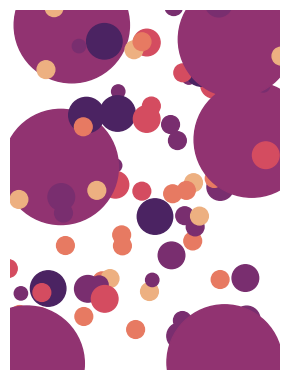

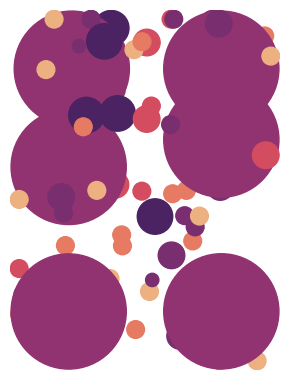

In [117]:
df_inventory = load_csv()
dims = (15, 20);
# items, xy = create_initial_plan(10, df_inventory, dims)
scatter_heights(items, xy, df_inventory, dims, 4)
xy_new = run_gradient_descent(items, df_inventory, dims, xy)
scatter_heights(items, xy_new, df_inventory, dims, 4);

KeyError: 'height'

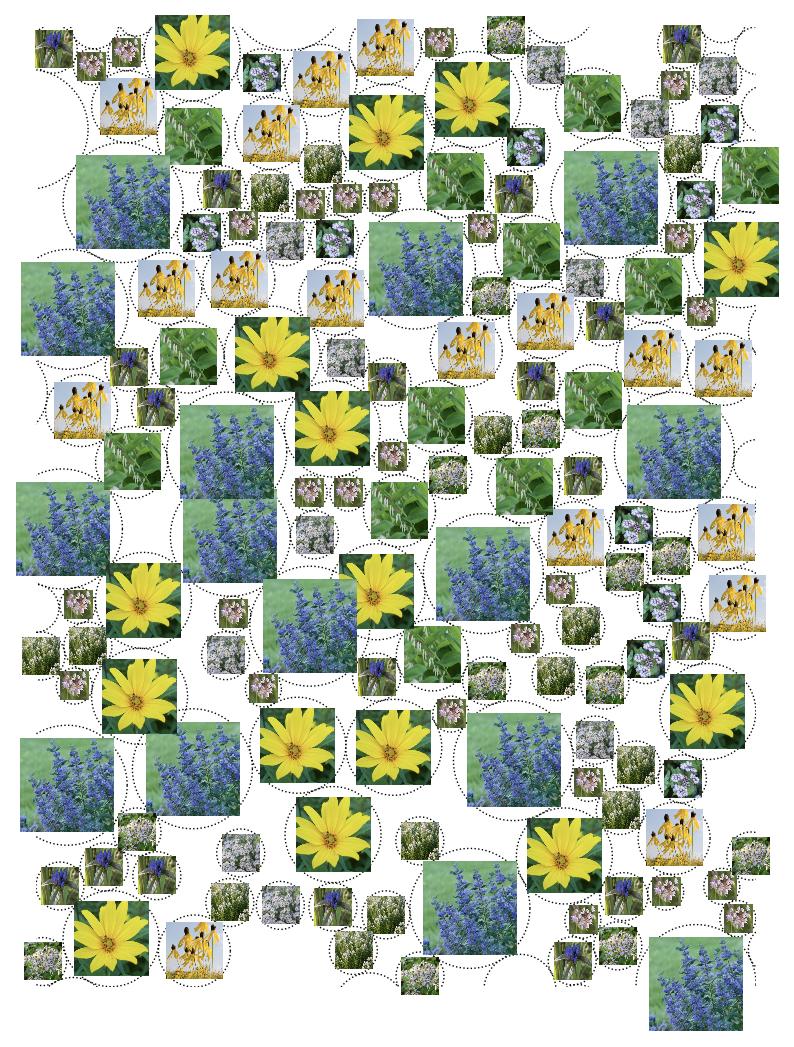

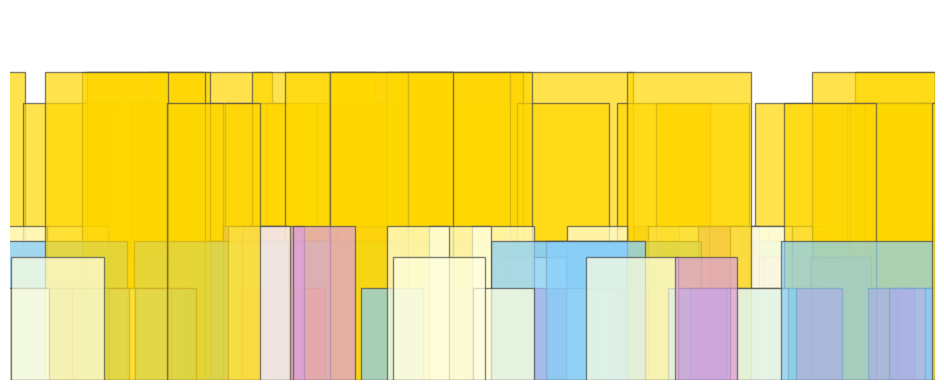

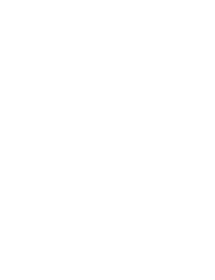

In [49]:
plot_garden(items, xy_new, df_inventory, dims)